# trokachat_pathway_drug_discovery Package Vignette

This notebook demonstrates how to use the `trokachat_pathway_drug_discovery` package to analyze pathway and drug data. We'll use the exact same file paths as in the original scripts to ensure consistent results.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the functions from our package
from trokachat_pathway_drug_discovery.elbow_detection import find_elbow_point, process_elbow_data
from trokachat_pathway_drug_discovery.visualization import plot_elbow_detection
from trokachat_pathway_drug_discovery.utils import print_directory_tree, ensure_directory_exists
from trokachat_pathway_drug_discovery.gene_mapping import get_mouse_mapping, collect_gene_names, transform_gene_file
from trokachat_pathway_drug_discovery.multixrank_utils import create_multixrank_config
from trokachat_pathway_drug_discovery.drug_enrichment import query_drug_info, update_drug_info

# Set up plotting
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")

/Users/troks27/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Elbow Detection for Cleaned Factors

In this section, we'll use our package to find the significant components in factor matrices by detecting elbow points in their value distributions.

In [2]:
# Function to extract factor number from filename - directly from our original script
def extract_factor_number(filename):
    match = re.search(r'Factor (\d+)', filename)
    return int(match.group(1)) if match else None

# Directory containing the cleaned data - using the exact path from the original script
input_dir = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/Decomposed Tensor/Cleaned Factors/cleaned_LigandReceptor_factors"

# List all CSV files in the directory and sort them by factor number
csv_files = sorted(
    [f for f in os.listdir(input_dir) if f.endswith('_cleaned.csv')],
    key=lambda x: extract_factor_number(x)
)

print(f"Found {len(csv_files)} CSV files for analysis.")

Found 16 CSV files for analysis.


Processing Factor 1_cleaned.csv (Factor 1)


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Elbow detected at index 32
Found 32 significant items (of 123 total)
Plot saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/Decomposed Tensor/Cleaned Factors/cleaned_LigandReceptor_factors/Factor 1_elbow_plot.pdf


,LigandReceptor,Value
0,Cxcl2_Cxcr2,13.260055
1,Cxcl3_Cxcr2,12.588718
2,Ccl3_Ccr1,8.891809
3,Csf3_Csf3r,6.877116
4,Ccl6_Ccr1,6.493191


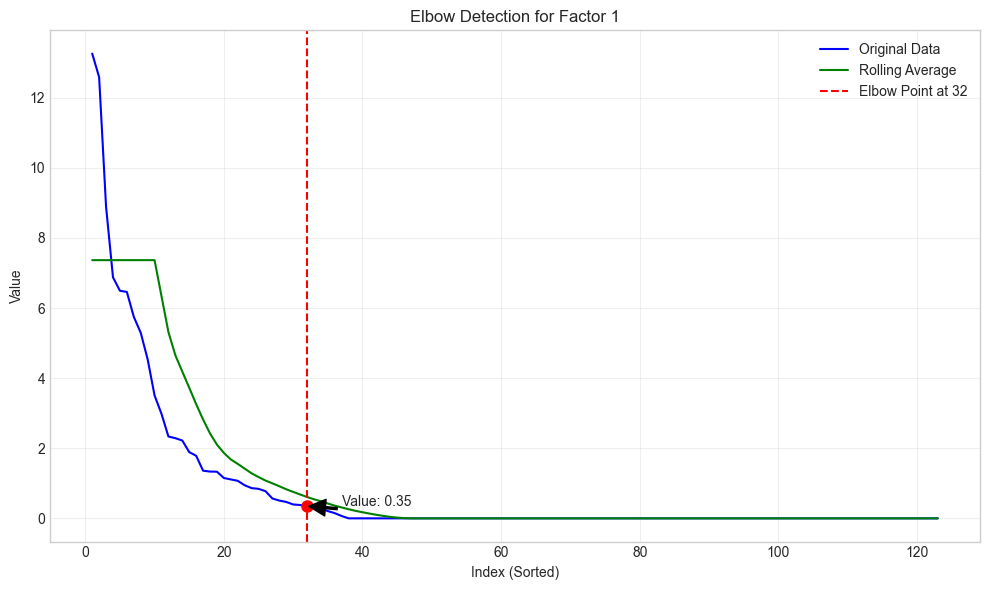

In [3]:
# Rolling window size - directly from the original script
window_size = 10

# Prepare Excel writer for saving results
output_excel_path = os.path.join(input_dir, "significant_data.xlsx")

# Using our package's functionality to process one sample file
if csv_files:
    # Just process the first file as an example
    sample_file = csv_files[0]
    file_path = os.path.join(input_dir, sample_file)
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Extract factor number
    factor_number = extract_factor_number(sample_file)
    print(f"Processing {sample_file} (Factor {factor_number})")
    
    # Check if 'Value' column exists
    if 'Value' not in df.columns:
        print(f"'Value' column not found in {sample_file}. Skipping this file.")
    else:
        # Sort values
        sorted_df = df.sort_values(by='Value', ascending=False).reset_index(drop=True)
        sorted_values = sorted_df['Value']
        
        # Use our package's find_elbow_point function
        elbow_idx, elbow_value, values, rolling_avg = find_elbow_point(
            sorted_values, 
            curve='convex', 
            direction='decreasing', 
            window_size=window_size
        )
        
        # Filter significant data
        significant_df = sorted_df[sorted_df['Value'] >= sorted_values.iloc[int(elbow_idx) - 1]]
        
        # Use our package's plot_elbow_detection function
        plot_title = f"Elbow Detection for {sample_file.replace('_cleaned.csv', '')}"
        plot_path = os.path.join(input_dir, f"{sample_file.replace('_cleaned.csv', '')}_elbow_plot.pdf")
        
        fig = plot_elbow_detection(
            sorted_values, 
            elbow_idx, 
            window_size=window_size,
            title=plot_title,
            save_path=plot_path
        )
        
        print(f"Elbow detected at index {elbow_idx}")
        print(f"Found {len(significant_df)} significant items (of {len(df)} total)")
        print(f"Plot saved to: {plot_path}")
        
        # Display a sample of significant items
        display(significant_df.head())

## 2. Processing All Factors with our Package

Now we'll process all factor files using our package's functions.

/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 1_cleaned.csv: Elbow at index 32; Data saved to sheet 'Factor 1'.
Processed Factor 2_cleaned.csv: Elbow at index 63; Data saved to sheet 'Factor 2'.
Processed Factor 3_cleaned.csv: Elbow at index 27; Data saved to sheet 'Factor 3'.
Processed Factor 4_cleaned.csv: Elbow at index 36; Data saved to sheet 'Factor 4'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 5_cleaned.csv: Elbow at index 69; Data saved to sheet 'Factor 5'.
Processed Factor 6_cleaned.csv: Elbow at index 67; Data saved to sheet 'Factor 6'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 7_cleaned.csv: Elbow at index 51; Data saved to sheet 'Factor 7'.
Processed Factor 8_cleaned.csv: Elbow at index 27; Data saved to sheet 'Factor 8'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 9_cleaned.csv: Elbow at index 27; Data saved to sheet 'Factor 9'.
Processed Factor 10_cleaned.csv: Elbow at index 37; Data saved to sheet 'Factor 10'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 11_cleaned.csv: Elbow at index 72; Data saved to sheet 'Factor 11'.
Processed Factor 12_cleaned.csv: Elbow at index 45; Data saved to sheet 'Factor 12'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 13_cleaned.csv: Elbow at index 26; Data saved to sheet 'Factor 13'.
Processed Factor 14_cleaned.csv: Elbow at index 50; Data saved to sheet 'Factor 14'.


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values
/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


Processed Factor 15_cleaned.csv: Elbow at index 45; Data saved to sheet 'Factor 15'.
Processed Factor 16_cleaned.csv: Elbow at index 49; Data saved to sheet 'Factor 16'.

All data has been successfully written to /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/Decomposed Tensor/Cleaned Factors/cleaned_LigandReceptor_factors/significant_data.xlsx


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


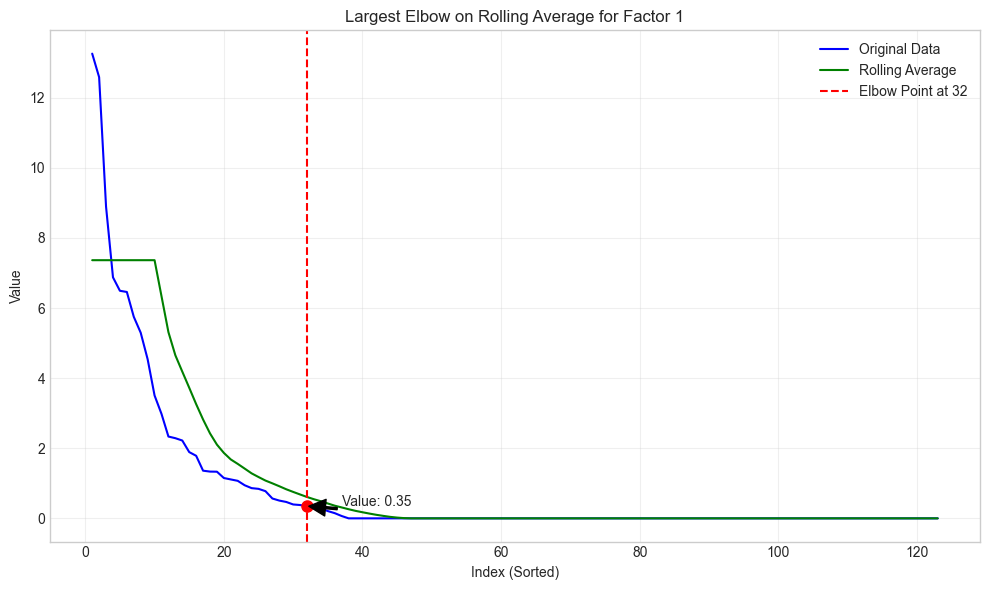

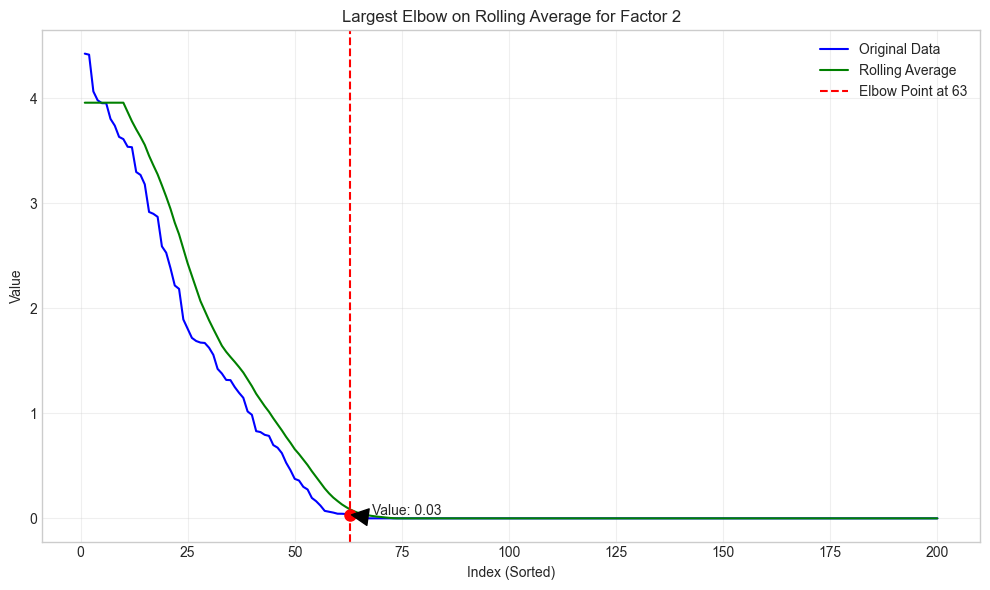

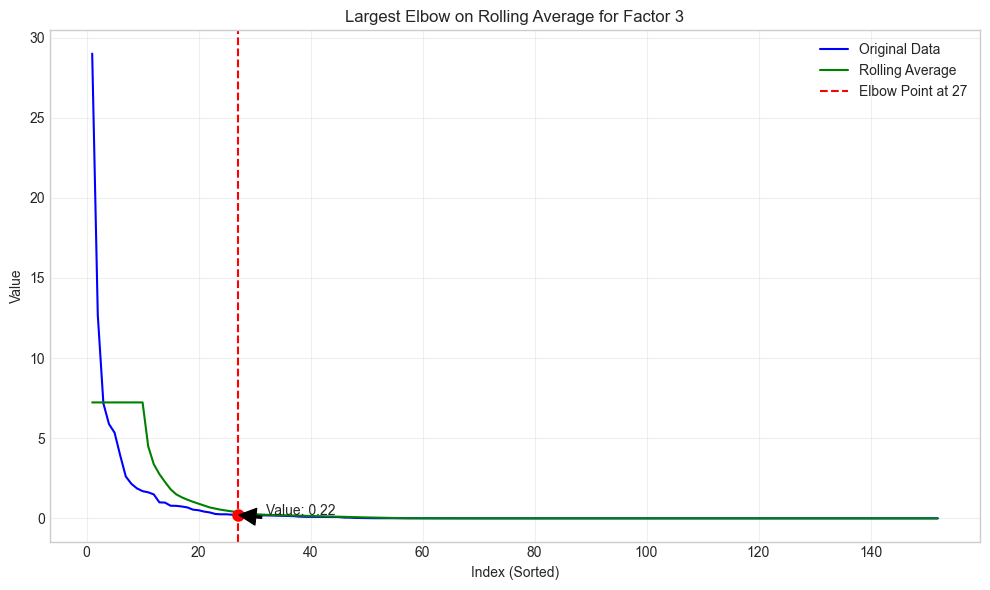

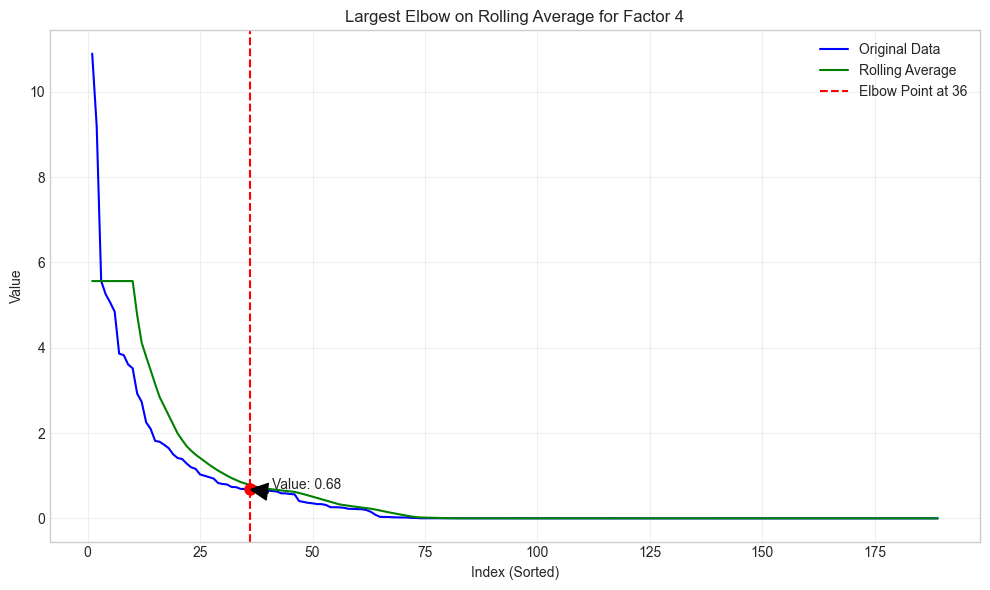

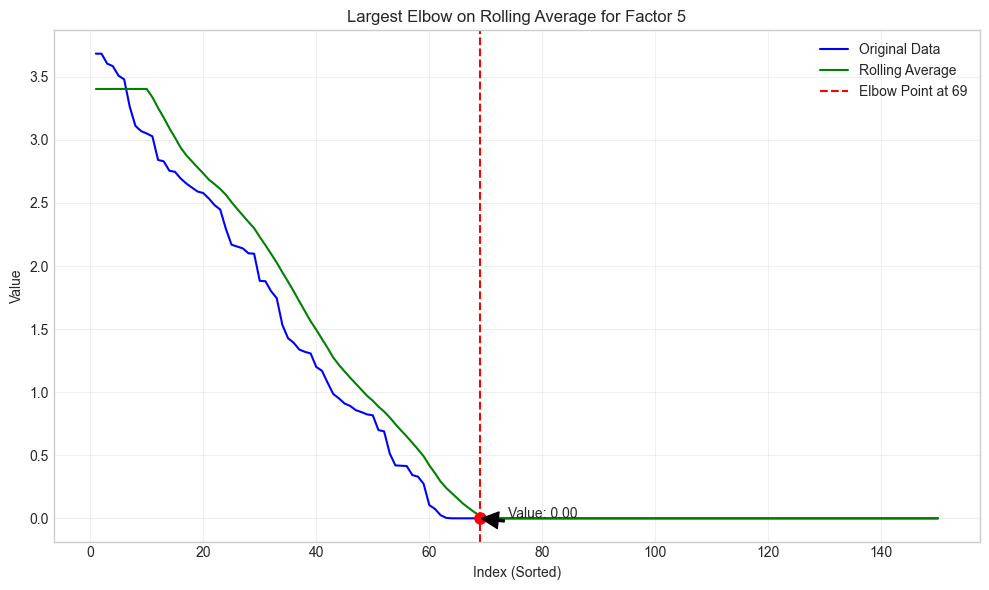

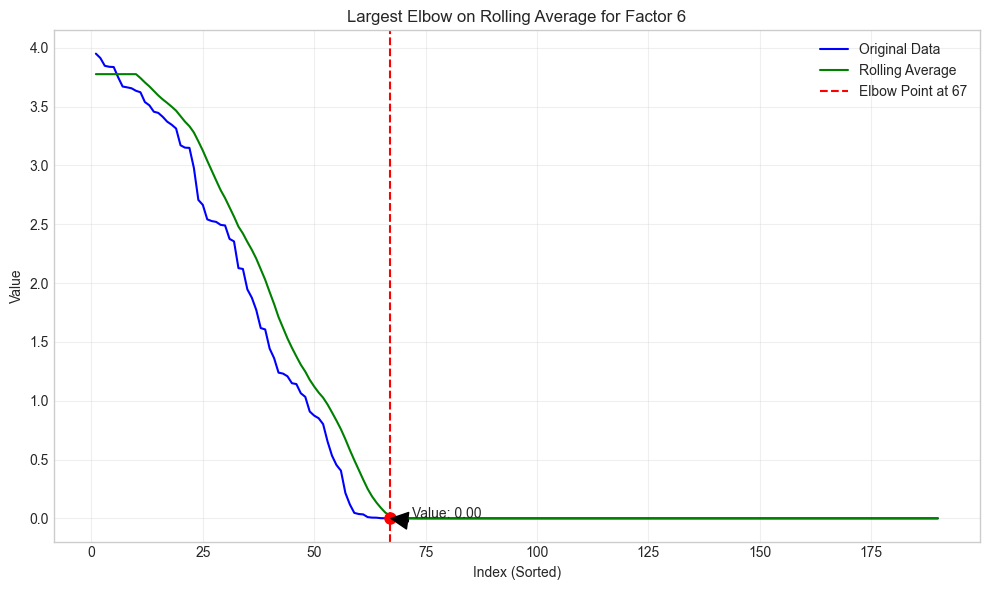

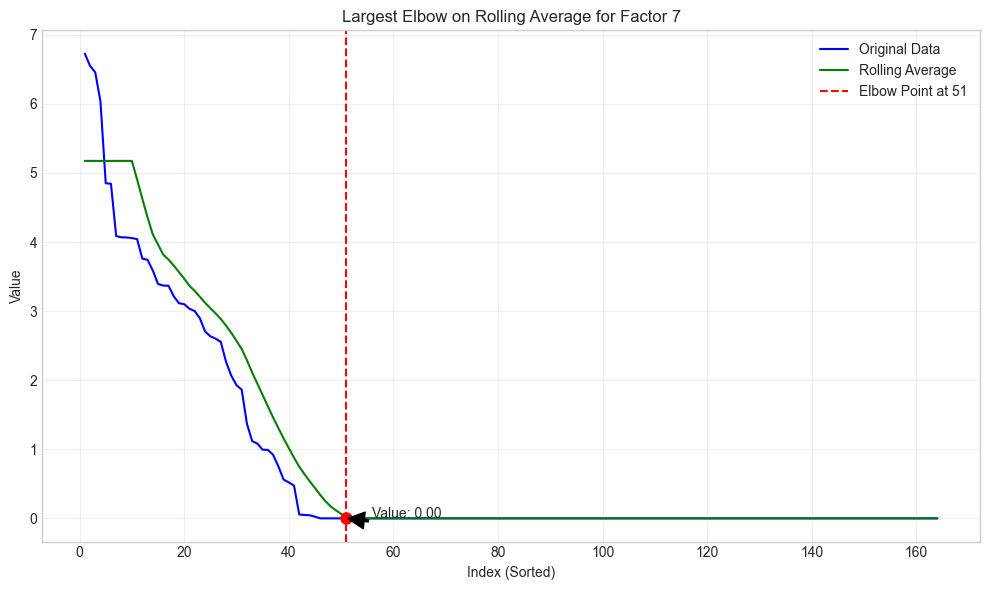

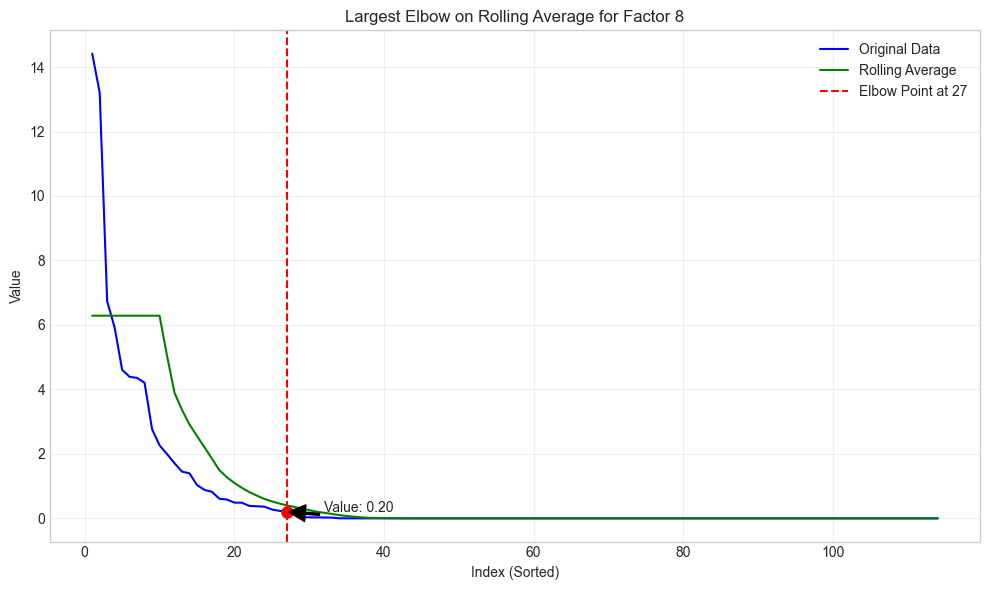

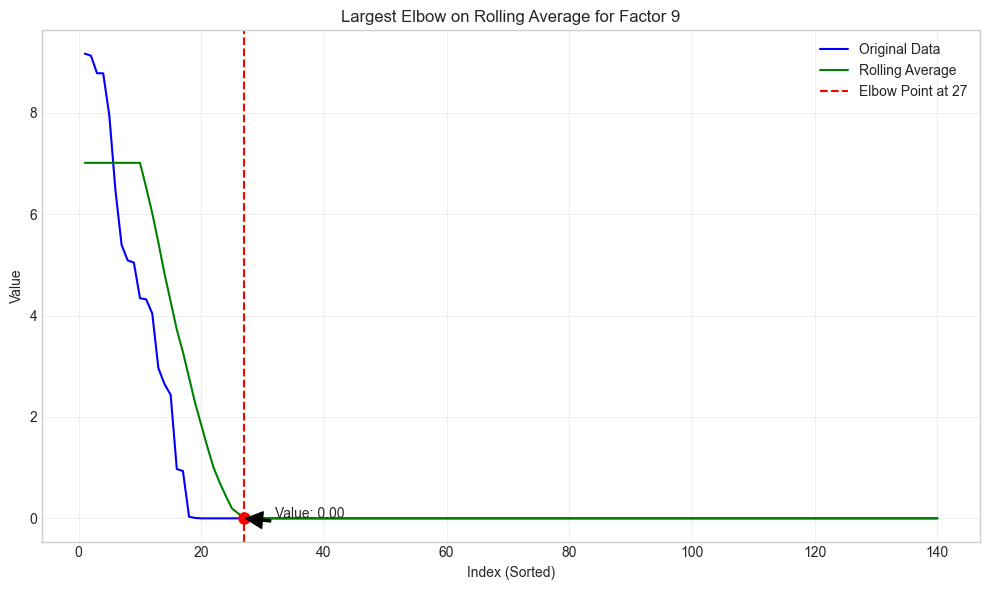

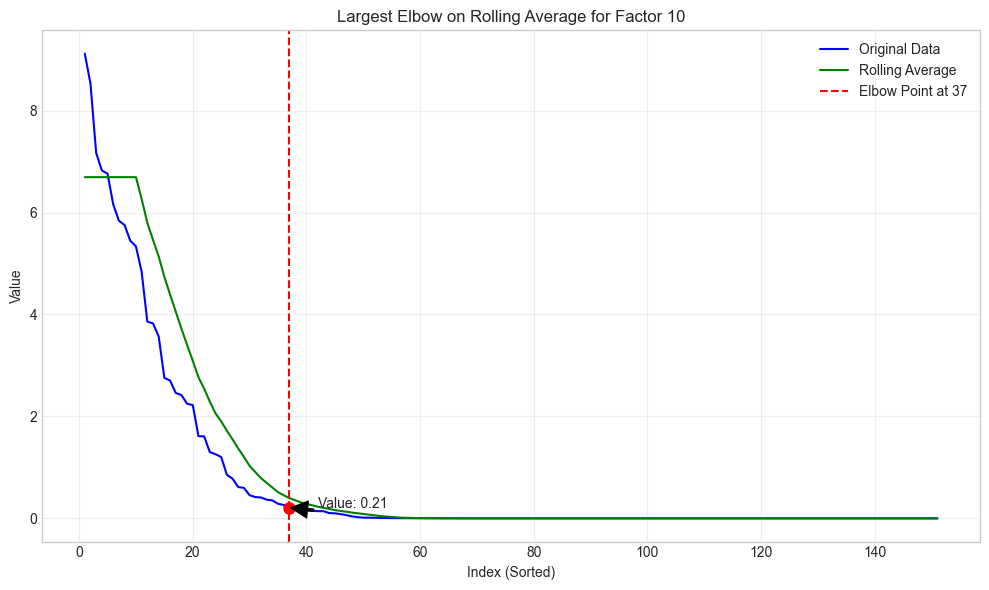

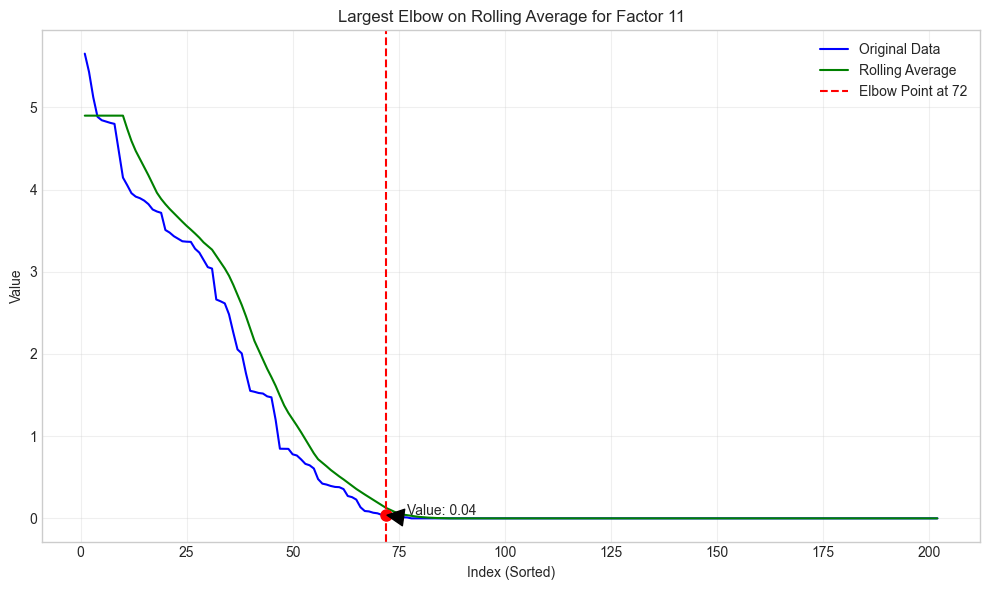

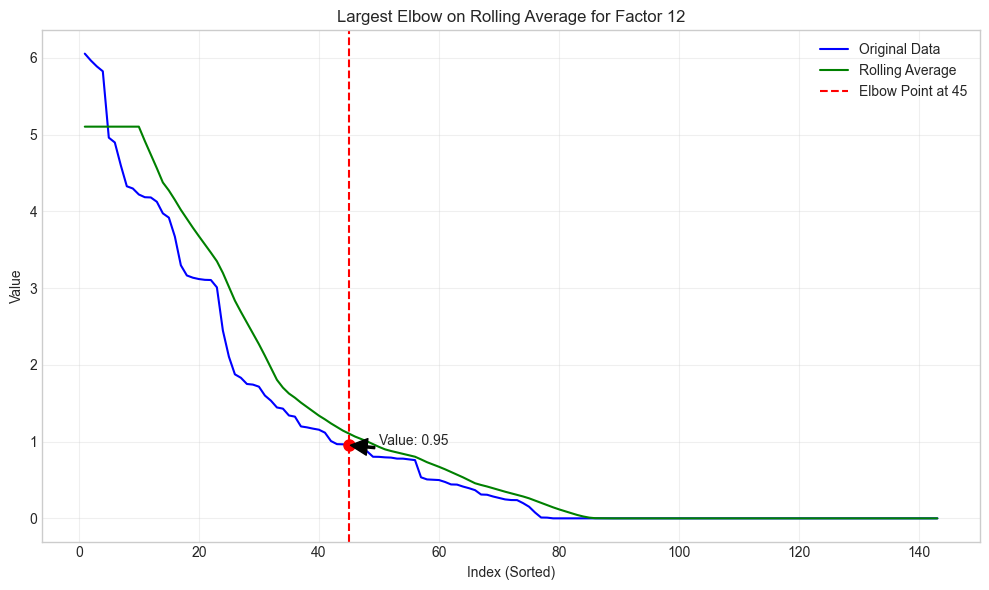

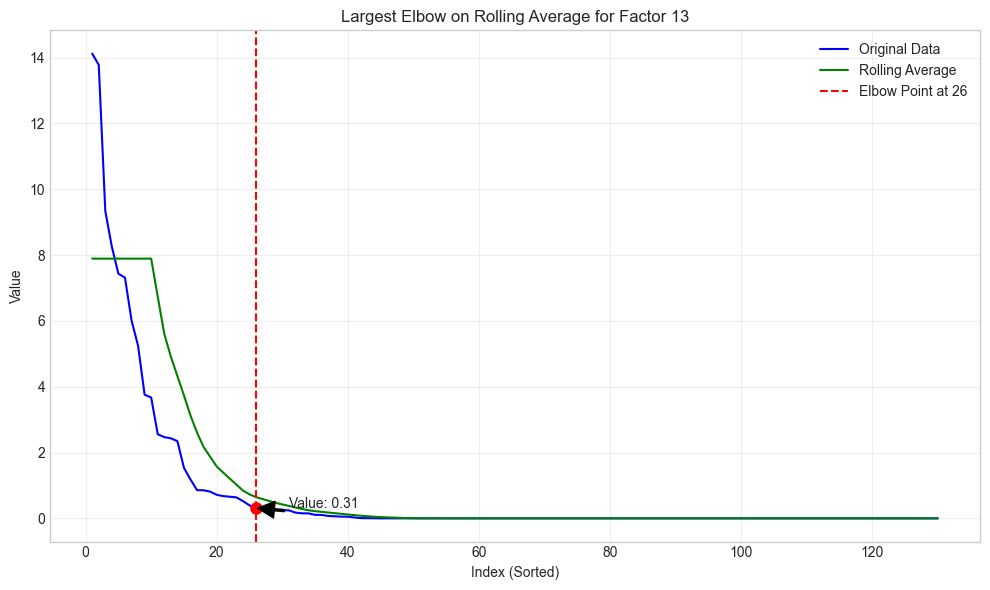

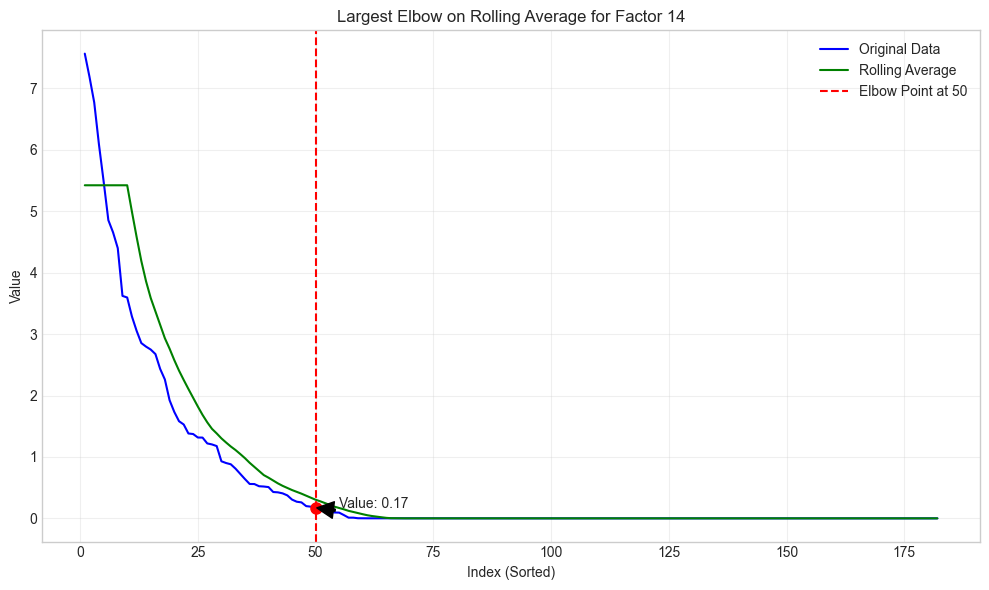

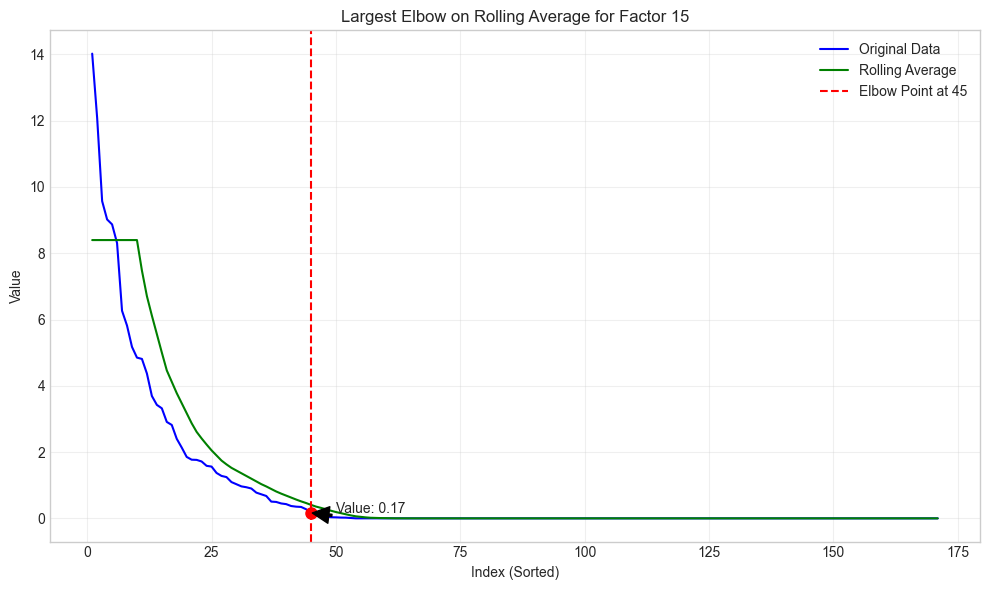

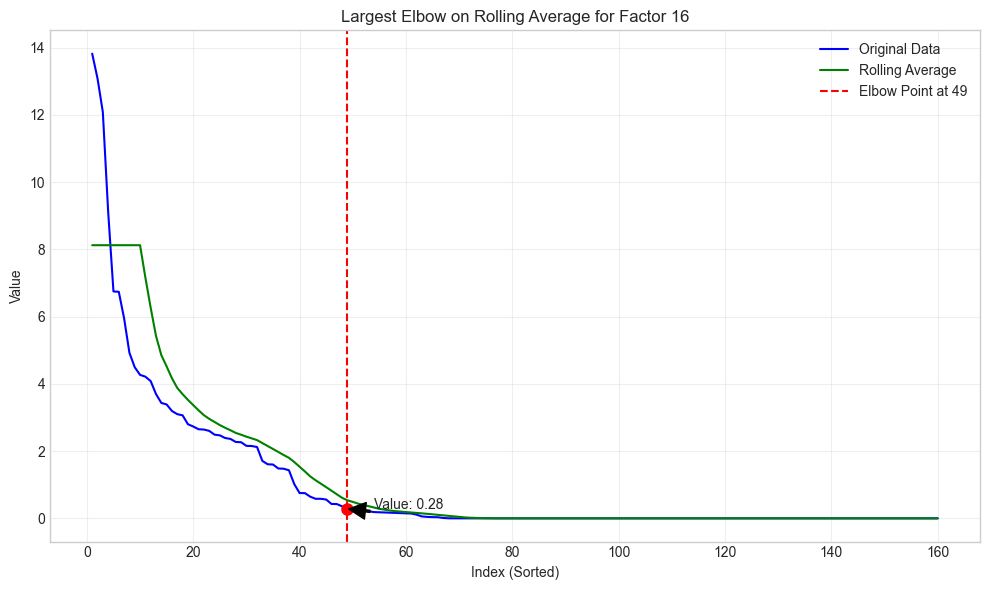

In [4]:
# Prepare for Excel output
output_excel_path = os.path.join(input_dir, "significant_data.xlsx")
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    for file in csv_files:
        # Load the cleaned data
        file_path = os.path.join(input_dir, file)
        df = pd.read_csv(file_path)
        
        # Extract factor number to name the sheet correctly
        factor_number = extract_factor_number(file)
        sheet_name = f"Factor {factor_number}" if factor_number else f"Factor {csv_files.index(file) + 1}"
        
        # Check if 'Value' column exists
        if 'Value' not in df.columns:
            print(f"'Value' column not found in {file}. Skipping this file.")
            continue
        
        # Use our package's process_elbow_data function
        elbow_idx, elbow_value, sorted_df, significant_df = process_elbow_data(
            df, 
            value_column='Value', 
            window_size=window_size, 
            curve='convex', 
            direction='decreasing'
        )
        
        # Generate the plot with our package's function
        plot_title = f"Largest Elbow on Rolling Average for {file.replace('_cleaned.csv', '')}"
        plot_path = os.path.join(input_dir, f"{file.replace('_cleaned.csv', '')}_largest_elbow_rolling_avg_plot.pdf")
        
        fig = plot_elbow_detection(
            sorted_df['Value'],
            elbow_idx,
            window_size=window_size,
            title=plot_title,
            save_path=plot_path
        )
        
        # Save the significant data to the Excel file
        significant_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"Processed {file}: Elbow at index {elbow_idx}; Data saved to sheet '{sheet_name}'.")
        
    print(f"\nAll data has been successfully written to {output_excel_path}")

## 3. Directory Structure Exploration

Let's use our package's utility function to explore the directory structure.

In [5]:
# Using the exact directory path from the original script
directory = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/TrokaChatML KG"

# Using our package's print_directory_tree function
print_directory_tree(directory)

''

## 4. Human to Mouse Gene Mapping

Now let's use our package to map human genes to mouse homologs using BioMart.

In [ ]:
# Define base input and output directories - using exact paths from the original script
base_in_dir = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/TrokaChatML KG"
base_out_dir = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/TrokaChatML KG_mouse"

# Make sure output directory exists using our package function
ensure_directory_exists(base_out_dir)

# List of files that contain gene names - using exact paths from the original script
multiplex_gene_files = [
    os.path.join(base_in_dir, "multiplex", "gene", "reactome_final.tsv"),
    os.path.join(base_in_dir, "multiplex", "gene", "complexes_final.tsv"),
    os.path.join(base_in_dir, "multiplex", "gene", "STRING_PPI_final.tsv")
]

bipartite_gene_files = [
    os.path.join(base_in_dir, "bipartite", "disease_gene.tsv"),
    os.path.join(base_in_dir, "bipartite", "pathway_gene.tsv"),
    os.path.join(base_in_dir, "bipartite", "factor_gene.tsv"),
    os.path.join(base_in_dir, "bipartite", "drug_gene.tsv")
]

# Specify which columns to extract gene names - using exact columns from the original script
multiplex_gene_columns = [0, 1]
bipartite_gene_columns = [1]

In [ ]:
# For demonstration, use our package's collect_gene_names function with a subset
if all(os.path.exists(f) for f in multiplex_gene_files[:1]):
    # Collect gene names from the first multiplex gene file
    sample_genes = collect_gene_names(multiplex_gene_files[:1], multiplex_gene_columns)
    
    # Only take the first 5 genes for demonstration
    demo_genes = sample_genes[:5] if len(sample_genes) > 5 else sample_genes
    
    print(f"Collected {len(sample_genes)} unique genes from {os.path.basename(multiplex_gene_files[0])}")
    print("Sample genes:")
    for gene in demo_genes:
        print(f"  - {gene}")
    
    # Use our package's get_mouse_mapping function
    try:
        print("\nQuerying BioMart for mouse homologs (this may take a moment)...")
        mapping = get_mouse_mapping(demo_genes)
        
        print("\nMouse homologs:")
        for human_gene, mouse_genes in mapping.items():
            print(f"  {human_gene} → {', '.join(mouse_genes)}")
    except Exception as e:
        print(f"Error querying BioMart: {str(e)}")
        print("Note: This requires an internet connection and BioMart service availability.")
else:
    print("Sample file not found. Make sure the directory structure is correct.")

In [ ]:
# Demonstrate our package's transform_gene_file function with a sample file
if multiplex_gene_files and os.path.exists(multiplex_gene_files[0]):
    # Sample input and output paths
    sample_input = multiplex_gene_files[0]
    sample_output = os.path.join(base_out_dir, "multiplex", "gene", os.path.basename(sample_input))
    
    # Ensure output directory exists
    ensure_directory_exists(os.path.dirname(sample_output))
    
    # Demonstration with a very small subset of genes to avoid long processing
    demo_mapping = {
        'GENE1': ['Gene1_mouse', 'Gene1a_mouse'],
        'GENE2': ['Gene2_mouse'],
        # Add more mappings if specific genes from the file are known
    }
    
    print(f"Demonstration of transform_gene_file with {os.path.basename(sample_input)}")
    print("Note: Using a mock mapping dictionary for demonstration purposes.")
    print(f"  Input: {sample_input}")
    print(f"  Output: {sample_output}")
    print("  Mapping columns: {}".format(multiplex_gene_columns))
    print("  Sample mapping: {}".format(dict(list(demo_mapping.items())[:2])))
    
    # Comment out actual transformation to avoid creating files
    # transformed_path = transform_gene_file(sample_input, sample_output, multiplex_gene_columns, demo_mapping)
    print("\nNote: Actual file transformation is commented out in this demonstration.")
else:
    print("Sample file not found. Make sure the directory structure is correct.")

## 5. MultiXRank Configuration Creation

Let's use our package to create a MultiXRank configuration file.

In [6]:
# Create MultiXRank configuration using our package function
# Using the exact configuration data from the original script
multixrank_config = {
    "seed": "seeds.txt",
    "self_loops": 1,
    "multiplex": {
        "pathway": {
            "layers": [
                "multiplex/pathway/pathway_pathway.tsv"
            ],
            "graph_type": ["01"]
        },
        "factor": {
            "layers": [
                "multiplex/factor/factor_factor.tsv"
            ],
            "graph_type": ["00"]
        },
        "disease": {
            "layers": [
                "multiplex/disease/disease_disease.tsv"
            ],
            "graph_type": ["00"]
        },
        "drug": {
            "layers": [
                "multiplex/drug/drug_drug.tsv"
            ],
            "graph_type": ["00"]
        },
        "gene": {
            "layers": [
                "multiplex/gene/STRING_PPI_final.tsv",
                "multiplex/gene/reactome_final.tsv",
                "multiplex/gene/complexes_final.tsv"
            ],
            "graph_type": ["01", "00", "00"]
        }
    },
    "bipartite": {
        "bipartite/drug_gene.tsv": {
            "source": "drug",
            "target": "gene",
            "graph_type": "00"
        },
        "bipartite/pathway_gene.tsv": {
            "source": "pathway",
            "target": "gene",
            "graph_type": "00"
        },
        "bipartite/disease_gene.tsv": {
            "source": "disease",
            "target": "gene",
            "graph_type": "01"
        },
        "bipartite/factor_gene.tsv": {
            "source": "factor",
            "target": "gene",
            "graph_type": "11"
        }
    }
}

# Using our package's create_multixrank_config function to generate YAML
config_yaml = create_multixrank_config(multixrank_config)

# Save to the exact path from the original script
config_path = '/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/run_info_mxr.yaml'
ensure_directory_exists(os.path.dirname(config_path))
with open(config_path, 'w') as file:
    file.write(config_yaml)

print(f"MultiXRank configuration saved to: {config_path}")
print("\nFirst 20 lines of the configuration:")
print("\n".join(config_yaml.split("\n")[:20]))

MultiXRank configuration saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/run_info_mxr.yaml

First 20 lines of the configuration:
bipartite:
  bipartite/disease_gene.tsv:
    graph_type: '01'
    source: disease
    target: gene
  bipartite/drug_gene.tsv:
    graph_type: '00'
    source: drug
    target: gene
  bipartite/factor_gene.tsv:
    graph_type: '11'
    source: factor
    target: gene
  bipartite/pathway_gene.tsv:
    graph_type: '00'
    source: pathway
    target: gene
multiplex:
  disease:
    graph_type:


## 5.5 Running MultiXRank Analysis

Now that we have created the configuration file, let's use our package to actually run the MultiXRank analysis. This is a key step where we process the factor data, generate seeds, and obtain rankings.


In [ ]:
# Import necessary package functions
from trokachat_pathway_drug_discovery.multixrank_utils import process_factor, run_multixrank_analysis

# Define the base paths from the original script
base_dir = '/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG'
factor_graphs_dir = os.path.join(base_dir, 'Factor Graphs')
config_file = os.path.join(base_dir, 'run_info_mxr.yaml')

# Find available factor folders
factor_folders = []
if os.path.exists(factor_graphs_dir):
    for folder in os.listdir(factor_graphs_dir):
        if folder.startswith('Factor'):
            factor_folder = os.path.join(factor_graphs_dir, folder)
            factor_folders.append(factor_folder)
    
    print(f"Found {len(factor_folders)} factor folders to process.")
    
    # Process one sample factor for demonstration
    if factor_folders:
        sample_folder = factor_folders[0]
        print(f"\nProcessing sample factor: {os.path.basename(sample_folder)}")
        
        try:
            # Use our package's process_factor function to run MultiXRank
            result = process_factor(sample_folder, base_dir, config_file)
            
            # Display the results
            print(f"\nMultiXRank analysis completed for {result['factor_name']}")
            print(f"Seeds file created at: {result['seeds_file']}")
            print(f"Results exported to: {result['output_dir']}")
            
            # If ranking DataFrame is available, show a sample
            if 'ranking_df' in result and not result['ranking_df'].empty:
                print("\nTop 5 ranked items:")
                display(result['ranking_df'].head(5))
        
        except Exception as e:
            print(f"Error running MultiXRank: {str(e)}")
            print("Note: This requires the multixrank package to be installed.")
            print("To install: pip install multixrank")
else:
    print(f"Factor graphs directory not found: {factor_graphs_dir}")





Found 16 factor folders to process.

Processing sample factor: Factor 13
Processing Factor 13...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 26


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038461538461538464' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])



MultiXRank analysis completed for Factor 13
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Results exported to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 13

Top 5 ranked items:


,multiplex,node,layer,score
0,disease,MONDO_0000001,multiplex/disease/disease_disease.tsv,0.000000e+00
1,disease,MONDO_0000004,multiplex/disease/disease_disease.tsv,5.694226e-08
2,disease,MONDO_0000009,multiplex/disease/disease_disease.tsv,5.778103e-06
3,disease,MONDO_0000044,multiplex/disease/disease_disease.tsv,8.487708e-08
4,disease,MONDO_0000078,multiplex/disease/disease_disease.tsv,5.949006e-10


In [10]:
results = {}
for folder in factor_folders:
    try:
        result = process_factor(folder, base_dir, config_file)
        results[os.path.basename(folder)] = result
        print(f"Successfully processed {os.path.basename(folder)}")
    except Exception as e:
        print(f"Error processing {os.path.basename(folder)}: {str(e)}")
        results[os.path.basename(folder)] = {'error': str(e)}

# Print summary of processing
print(f"\nProcessed {len(results)} factor folders")
print(f"Successful: {sum(1 for r in results.values() if 'error' not in r)}")
print(f"Failed: {sum(1 for r in results.values() if 'error' in r)}")

Processing Factor 13...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 26


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038461538461538464' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 13
Processing Factor 14...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 50


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 14
Processing Factor 15...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 45


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.022222222222222223' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 15
Processing Factor 12...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 45


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.022222222222222223' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 12
Processing Factor 3...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 27


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.037037037037037035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 3
Processing Factor 4...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 36


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.027777777777777776' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 4
Processing Factor 5...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 69


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.014492753623188406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 5
Processing Factor 2...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 63


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1184d1180>>
Traceback (most recent call last):
  File "/Users/troks27/mambaforge/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.015873015873015872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 2
Processing Factor 10...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 37


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02702702702702703' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 10
Processing Factor 11...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 72


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.013888888888888888' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 11
Processing Factor 16...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 49


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02040816326530612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 16
Processing Factor 7...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 51


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0196078431372549' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 7
Processing Factor 9...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 27


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.037037037037037035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 9
Processing Factor 8...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 27


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.037037037037037035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 8
Processing Factor 1...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 32


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 1
Processing Factor 6...
Seeds file created at: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/seeds.txt
Total number of unique seeds: 67


/Users/troks27/mambaforge/lib/python3.10/site-packages/multixrank/Seed.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.014925373134328358' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seed_score_df.loc[seed_label, layer.key] = multiplex.eta * layer.tau / len(self.multiplex_seed_list2d[multiplex_idx])


Successfully processed Factor 6

Processed 16 factor folders
Successful: 16
Failed: 0


## 6. Finding and Processing MultiXRank Output Files

Let's use our package to find and process the output files from MultiXRank analysis.

In [7]:
# Using the main directory from the original script
main_dir = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/"

# List of file types to process - using exact file types from the original script
file_types = ["multiplex_disease.tsv", "multiplex_drug.tsv", "multiplex_pathway.tsv", "multiplex_gene.tsv"]

# Use our finding functions to locate matching files
from trokachat_pathway_drug_discovery.data_processing import find_files
matching_files = []
for file_type in file_types:
    matching_files.extend(find_files(main_dir, patterns=[file_type]))

# Print the results
print(f"Found {len(matching_files)} files matching the specified types.")
for i, file in enumerate(matching_files[:5]):
    print(f"  {i+1}. {os.path.basename(file)}")
if len(matching_files) > 5:
    print(f"  ... and {len(matching_files) - 5} more")

Found 64 files matching the specified types.
  1. multiplex_disease.tsv
  2. multiplex_disease.tsv
  3. multiplex_disease.tsv
  4. multiplex_disease.tsv
  5. multiplex_disease.tsv
  ... and 59 more


Processing multiplex_disease.tsv
Elbow detected at index 363
Kept 363 of 10854 rows after filtering
Plot saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 10/multiplex_disease_analysis/multiplex_disease_elbow_plot.pdf
Filtered data saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 10/multiplex_disease_filtered.tsv


/Users/troks27/Desktop/DIAB_NG_TrokaChatML/trokachat_pathway_drug_discovery/visualization.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_avg = pd.Series(values).rolling(window=window_size).mean().fillna(method='bfill').values


,multiplex,node,score
0,disease,MONDO_0007191,0.000264
1,disease,MONDO_0005249,0.000218
2,disease,MONDO_0004989,0.000197
3,disease,MONDO_0005271,0.000196
4,disease,MONDO_0005154,0.000194


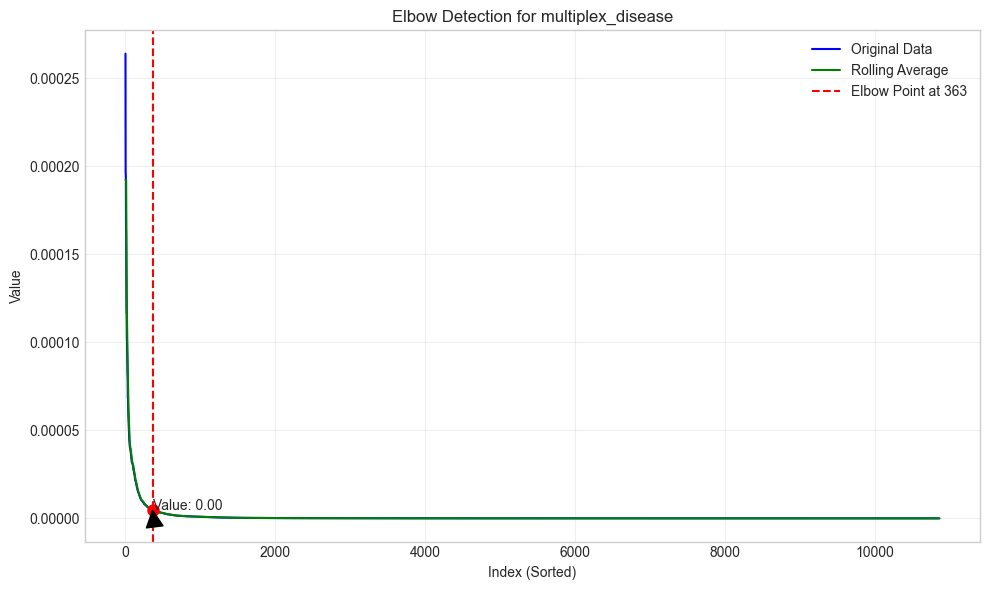

In [8]:
# Process a sample file using our package's functions
if matching_files:
    # Take the first file for demonstration
    sample_file = matching_files[0]
    print(f"Processing {os.path.basename(sample_file)}")
    
    # Load the file
    from trokachat_pathway_drug_discovery.data_processing import load_csv_file
    df = load_csv_file(sample_file, sep='\t')
    
    # Check if 'score' column exists
    if 'score' not in df.columns:
        print(f"'score' column not found in {sample_file}. Cannot process.")
    else:
        # Use our package's process_elbow_data function
        window_size = 10  # From the original script
        elbow_idx, elbow_value, sorted_df, filtered_df = process_elbow_data(
            df, 
            value_column='score', 
            window_size=window_size,
            curve='convex', 
            direction='decreasing'
        )
        
        # Create analysis directory using our package's function
        basename = os.path.splitext(os.path.basename(sample_file))[0]
        analysis_dir = os.path.join(os.path.dirname(sample_file), f"{basename}_analysis")
        ensure_directory_exists(analysis_dir)
        
        # Create the plot using our package's function
        plot_path = os.path.join(analysis_dir, f"{basename}_elbow_plot.pdf")
        fig = plot_elbow_detection(
            sorted_df['score'], 
            elbow_idx, 
            window_size=window_size,
            title=f"Elbow Detection for {basename}",
            save_path=plot_path
        )
        
        # Save the filtered data
        filtered_path = os.path.join(os.path.dirname(sample_file), f"{basename}_filtered.tsv")
        filtered_df.to_csv(filtered_path, sep='\t', index=False)
        
        print(f"Elbow detected at index {elbow_idx}")
        print(f"Kept {len(filtered_df)} of {len(df)} rows after filtering")
        print(f"Plot saved to: {plot_path}")
        print(f"Filtered data saved to: {filtered_path}")
        
        # Display a sample of the filtered data
        display(filtered_df.head())
else:
    print("No matching files found for processing.")

## 6.2 Processing All MultiXRank Output Files

Now let's demonstrate how to process all matching files, as in the original script:


In [14]:
# Using the main directory from the original script
main_dir = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/"

# List of file types to process - using exact file types from the original script
file_types = ["multiplex_disease.tsv", "multiplex_drug.tsv", "multiplex_pathway.tsv", "multiplex_gene.tsv"]

# Use our finding functions to locate matching files
matching_files = []
for file_type in file_types:
    matching_files.extend(find_files(main_dir, patterns=[file_type]))

print(f"Found {len(matching_files)} files matching the specified types.")

# Process all files using a direct approach to avoid function issues
if matching_files:
    # Track processing results
    results = {}
    
    # Process each file
    for i, file_path in enumerate(matching_files):
        print(f"\nProcessing file {i+1}/{len(matching_files)}: {os.path.basename(file_path)}")
        
        # Load the file
        df = load_csv_file(file_path, sep='\t')
        
        # Check if 'score' column exists
        if 'score' not in df.columns:
            print(f"'score' column not found in {file_path}. Skipping this file.")
            continue
        
        # Rolling window size from the original script
        window_size = 10
        
        try:
            # Sort the DataFrame by 'score' in decreasing order
            sorted_df = df.sort_values(by='score', ascending=False).reset_index(drop=True)
            sorted_values = sorted_df['score']
            
            # Create x-data
            x_data = np.arange(1, len(sorted_values) + 1)
            
            # Calculate the rolling average
            rolling_avg = sorted_values.rolling(window=window_size).mean().dropna()
            
            # Apply KneeLocator on rolling average data, skipping the first (window_size-1) points
            from kneed import KneeLocator
            kneedle = KneeLocator(x_data[window_size-1:], rolling_avg, curve='convex', direction='decreasing')
            elbow_x = kneedle.elbow
            
            # Map the elbow point to the original data
            if elbow_x is not None:
                elbow_point = elbow_x
            else:
                elbow_point = 0  # Fallback if no elbow is found
            
            # Filter data based on elbow point
            if elbow_point > 0 and elbow_point < len(sorted_df):
                significant_df = sorted_df[sorted_df['score'] >= sorted_values.iloc[int(elbow_point) - 1]]
            else:
                significant_df = sorted_df  # Use all data if no valid elbow point
            
            # Create analysis directory
            basename = os.path.splitext(os.path.basename(file_path))[0]
            analysis_dir = os.path.join(os.path.dirname(file_path), f"{basename}_analysis")
            os.makedirs(analysis_dir, exist_ok=True)
            
            # Create the plot manually
            plt.figure(figsize=(10, 5))
            plt.plot(x_data, sorted_values, label='Original Data', color='blue')
            plt.plot(x_data[window_size-1:], rolling_avg, label='Rolling Average', color='green')
            plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point at {elbow_point}')
            plt.title(f"Elbow Detection for {basename}")
            plt.xlabel("Index (Sorted in Decreasing Order)")
            plt.ylabel("Score")
            plt.legend()
            
            # Save the plot
            plot_path = os.path.join(analysis_dir, f"{basename}_elbow_plot.pdf")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to prevent display in notebook
            
            # Save the filtered data
            filtered_path = os.path.join(os.path.dirname(file_path), f"{basename}_filtered.tsv")
            significant_df.to_csv(filtered_path, sep='\t', index=False)
            
            # Store results
            results[file_path] = {
                'status': 'success',
                'elbow_point': elbow_point,
                'total_rows': len(df),
                'significant_rows': len(significant_df),
                'plot_path': plot_path,
                'filtered_path': filtered_path
            }
            
            print(f"  Elbow detected at index {elbow_point}")
            print(f"  Found {len(significant_df)} significant items (of {len(df)} total)")
            print(f"  Plot saved to: {plot_path}")
            print(f"  Filtered data saved to: {filtered_path}")
            
        except Exception as e:
            print(f"  Error processing {file_path}: {str(e)}")
            results[file_path] = {'status': 'error', 'error': str(e)}
    
    # Print summary
    print("\nProcessing Summary:")
    print(f"Successfully processed: {sum(1 for r in results.values() if r.get('status') == 'success')} files")
    print(f"Failed to process: {sum(1 for r in results.values() if r.get('status') == 'error')} files")
    
    # Display details for the first few successful files
    successful_files = [f for f, r in results.items() if r.get('status') == 'success']
    if successful_files:
        print("\nDetails for the first successful file:")
        sample_result = results[successful_files[0]]
        for key, value in sample_result.items():
            if key != 'status':
                print(f"  {key}: {value}")
else:
    print("No matching files found for processing.")

Found 64 files matching the specified types.

Processing file 1/64: multiplex_disease.tsv
  Elbow detected at index 363
  Found 363 significant items (of 10854 total)
  Plot saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 10/multiplex_disease_analysis/multiplex_disease_elbow_plot.pdf
  Filtered data saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 10/multiplex_disease_filtered.tsv

Processing file 2/64: multiplex_disease.tsv
  Elbow detected at index 211
  Found 211 significant items (of 10854 total)
  Plot saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 9/multiplex_disease_analysis/multiplex_disease_elbow_plot.pdf
  Filtered data saved to: /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 9/multiplex_disease_filtered.tsv

Processing file 3/64: multiplex_disease.tsv
  Elbow detected at index 357
  Found 357 signif

## 7. Drug Information Enrichment

Finally, let's demonstrate using our package for enriching drug data with information from ChEMBL.

In [4]:
# First, check if ChEMBL downloader is installed
try:
    import chembl_downloader
    chembl_available = True
    print("ChEMBL downloader package is available.")
except ImportError:
    chembl_available = False
    print("ChEMBL downloader package is not installed.")
    print("To install: pip install chembl_downloader")

ChEMBL downloader package is available.


In [5]:
# Use our package's query_drug_info function to query a sample drug
if chembl_available:
    # Query a specific drug using the same example from the original script
    drug_name = 'VEDOLIZUMAB'
    print(f"Querying information for drug: {drug_name}")
    
    # Use our package's query_drug_info function
    drug_id, drug_info = query_drug_info(drug_name, by_chembl_id=False)
    
    if drug_info and 'error' not in drug_info:
        print("\nDrug Information:")
        for key, value in drug_info.items():
            print(f"  {key}: {value}")
    else:
        error_msg = drug_info.get('error', 'No information found') if drug_info else 'No information found'
        print(f"Error or no data: {error_msg}")
else:
    print("Skipping drug query example since ChEMBL downloader is not available.")

Querying information for drug: VEDOLIZUMAB

Drug Information:
  Mechanism: Integrin alpha-4/beta-7 inhibitor
  Clinical Trials: Crohn Disease; Colitis, Ulcerative; HIV Infections; Immune System Diseases; Celiac Disease; Melanoma; Colitis; Infections; Diabetes Mellitus, Type 1; Inflammatory Bowel Diseases


In [8]:
# Find drug files for enrichment using paths from the original script
base_path = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/"
drug_files = []

for i in range(1, 17):
    folder = f"output_Factor {i}"
    file_path = os.path.join(base_path, folder, "multiplex_drug_filtered.tsv")
    if os.path.exists(file_path):
        drug_files.append(file_path)

print(f"Found {len(drug_files)} drug files for potential enrichment.")
for i, file in enumerate(drug_files[:3]):
    print(f"  {i+1}. {os.path.basename(os.path.dirname(file))}/{os.path.basename(file)}")
if len(drug_files) > 3:
    print(f"  ... and {len(drug_files) - 3} more")

Found 16 drug files for potential enrichment.
  1. output_Factor 1/multiplex_drug_filtered.tsv
  2. output_Factor 2/multiplex_drug_filtered.tsv
  3. output_Factor 3/multiplex_drug_filtered.tsv
  ... and 13 more


## 7.1. Drug Information Enrichment

This is how you would add the MOA and clinical trial metadata to all drug outputs from the MultiXRank computations.

In [3]:
# Define your input variables
base_path = "/Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/"
folders = [f"output_Factor {i}" for i in range(1, 17)]
tsv_filename = "multiplex_drug_filtered.tsv"
drug_column = "node"
import chembl_downloader
# Run the function
update_drug_info(base_path, folders, tsv_filename, drug_column)

Updating TSV files: 100%|██████████| 16/16 [00:00<00:00, 1636.84it/s]

Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 6/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 10/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 4/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 3/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 2/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 5/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/output_Factor 1/multiplex_drug_filtered_updated.tsv
Updated /Users/troks27/Desktop/DIAB_NG_TrokaChatML/TrokaChat/KG/TrokaChatML KG/out

## Conclusion

This notebook has demonstrated how to use the various functions in the `trokachat_pathway_drug_discovery` package for:

1. **Elbow Detection**: Using `find_elbow_point` and `process_elbow_data` to identify significant components in factor matrices.

2. **Visualization**: Using `plot_elbow_detection` to create informative plots showing the elbow points.

3. **Directory Exploration**: Using `print_directory_tree` to explore the structure of knowledge graph directories.

4. **Gene Mapping**: Using `collect_gene_names`, `get_mouse_mapping`, and `transform_gene_file` to map human genes to mouse homologs.

5. **MultiXRank Configuration**: Using `create_multixrank_config` to create YAML configurations for network analysis.

6. **File Processing**: Using `find_files` and `load_csv_file` to locate and process MultiXRank output files.

7. **Drug Enrichment**: Using `query_drug_info` and `enrich_drug_data` to add mechanism and clinical trial information to drug data.

All of these functions are now available as part of a structured, maintainable package that can be easily reused across different projects.